<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/nguwijy/deep_branching_with_domain/blob/master/notebooks/dolphinx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

## PDE solver using dolfinx
To run this notebook,
make sure the dolphinx environment is actiavated via
`bash scripts/start_dolphinx.sh`.

In [1]:
from dolfinx.plot import create_vtk_mesh
from scipy import spatial
import pyvista
import matplotlib.pyplot as plt
import os

if not os.path.isdir("logs/dolphinx"):
    os.mkdir("logs/dolphinx")

def plot_quiver(V, u_n, title, nb_points=21):
    cells, types, x = create_vtk_mesh(V)
    tree = spatial.KDTree(x[:, :2])

    # smaller subset of x
    nb_points = 21
    x1, x2 = np.meshgrid(
        np.linspace(-1, 1, nb_points + 2)[1:-1],
        np.linspace(-1, 1, nb_points + 1)[1:-1]
    )
    # get the nearest point
    val, idx = tree.query(np.stack((x1, x2)).reshape(2, -1).T)

    u_tmp = u_n.x.array.reshape(x.shape[0], V.dofmap.index_map_bs)
    u1, u2 = u_tmp[idx, 0], u_tmp[idx, 1]
    x1, x2 = x[idx, 0], x[idx, 1]

    plt.axis('scaled')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.quiver(x1, x2, u1, u2)
    plt.savefig(f"logs/dolphinx/{title}.png", dpi=300)
    plt.title(title)
    plt.show()

  values[0] = fprime(x[1]) / f(x[1]) * np.exp(-g(x[0]) / f(x[1]))

  values[0] = fprime(x[1]) / f(x[1]) * np.exp(-g(x[0]) / f(x[1]))

  values[1] = gprime(x[0]) / g(x[0]) * np.exp(-g(x[0]) / f(x[1]))



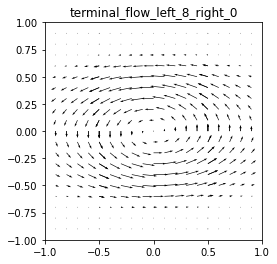

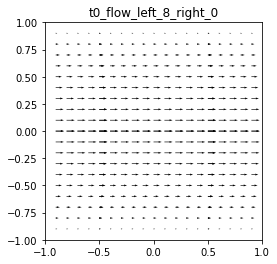

In [2]:
from mpi4py import MPI
from petsc4py import PETSc
import numpy as np
import pyvista

from dolfinx.fem import Constant,Function, FunctionSpace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
from dolfinx.io import XDMFFile
from dolfinx.mesh import create_unit_square, create_rectangle
from dolfinx.plot import create_vtk_mesh
from ufl import (FacetNormal, FiniteElement, Identity,TestFunction, TrialFunction, VectorElement,
                 div, dot, ds, dx, inner, lhs, nabla_grad, rhs, sym)

mesh = create_rectangle(
    MPI.COMM_WORLD,
    [np.array([-1, -1]), np.array([1, 1])],
    [10, 10]
)
t = 0
num_steps = 1000
T = 20
dt = T / num_steps
nu = .001

v_cg2 = VectorElement("CG", mesh.ufl_cell(), 2)
s_cg1 = FiniteElement("CG", mesh.ufl_cell(), 1)
V = FunctionSpace(mesh, v_cg2)
Q = FunctionSpace(mesh, s_cg1)

u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

def walls(x):
    return np.logical_or(np.isclose(x[1],-1), np.isclose(x[1],1))
wall_dofs = locate_dofs_geometrical(V, walls)
u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
bcu_noslip = dirichletbc(u_noslip, wall_dofs, V)
bcp_noslip = dirichletbc(PETSc.ScalarType(0), wall_dofs, Q)

def inflow(x):
    return np.isclose(x[0],-1)
def outflow(x):
    return np.isclose(x[0],1)
inflow_dofs = locate_dofs_geometrical(Q, inflow)
outflow_dofs = locate_dofs_geometrical(Q, outflow)
bc_inflow = dirichletbc(PETSc.ScalarType(8), inflow_dofs, Q)
bc_outflow = dirichletbc(PETSc.ScalarType(0), outflow_dofs, Q)

bcu = [bcu_noslip]
bcp = [bc_inflow, bc_outflow]
# bcp = [bcp_noslip]

alpha_for_f, beta_for_f = 2, 2
def f(x):
    return (1-x)**alpha_for_f * (1+x)**beta_for_f
def fprime(x):
    return (
        ((beta_for_f - alpha_for_f) - (beta_for_f + alpha_for_f) * x)
        * (1-x)**(alpha_for_f-1) 
        * (1+x)**(beta_for_f-1)
    )
def g(x):
    return 1 + x**2
def gprime(x):
    return 2 * x

def u_terminal(x):
    values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType)
    values[0] = fprime(x[1]) / f(x[1]) * np.exp(-g(x[0]) / f(x[1]))
    values[0] = np.where(
        np.logical_or(np.isclose(f(x[1]),0), np.isclose(g(x[0]),0)),
        np.zeros_like(values[0]),
        values[0]
    )
    values[1] = gprime(x[0]) / g(x[0]) * np.exp(-g(x[0]) / f(x[1]))
    values[1] = np.where(
        np.logical_or(np.isclose(f(x[1]),0), np.isclose(g(x[0]),0)),
        np.zeros_like(values[1]),
        values[1]
    )
    return values

u_n = Function(V)
u_n.name = "u_n"
u_n.interpolate(u_terminal)
U = 0.5 * (u_n + u)
n = FacetNormal(mesh)
f = Constant(mesh, PETSc.ScalarType((0,0)))
k = Constant(mesh, PETSc.ScalarType(dt))
mu = Constant(mesh, PETSc.ScalarType(1))
rho = Constant(mesh, PETSc.ScalarType(1))

# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(u.geometric_dimension())

# Define the variational problem for the first step
p_n = Function(Q)
p_n.name = "p_n"
F1 = rho*dot((u - u_n) / k, v)*dx
F1 += rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx
F1 += inner(sigma(U, p_n), epsilon(v))*dx
F1 += dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds
F1 -= dot(f, v)*dx
a1 = form(lhs(F1))
L1 = form(rhs(F1))

A1 = assemble_matrix(a1, bcs=bcu)
A1.assemble()
b1 = create_vector(L1)

# Define variational problem for step 2
u_ = Function(V)
a2 = form(dot(nabla_grad(p), nabla_grad(q))*dx)
L2 = form(dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx)
A2 = assemble_matrix(a2, bcs=bcp)
A2.assemble()
b2 = create_vector(L2)

# Define variational problem for step 3
p_ = Function(Q)
a3 = form(dot(u, v)*dx)
L3 = form(dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx)
A3 = assemble_matrix(a3)
A3.assemble()
b3 = create_vector(L3)

# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.HYPRE)
pc1.setHYPREType("boomeramg")

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm)
solver2.setOperators(A2)
solver2.setType(PETSc.KSP.Type.BCGS)
pc2 = solver2.getPC()
pc2.setType(PETSc.PC.Type.HYPRE)
pc2.setHYPREType("boomeramg")

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm)
solver3.setOperators(A3)
solver3.setType(PETSc.KSP.Type.CG)
pc3 = solver3.getPC()
pc3.setType(PETSc.PC.Type.SOR)

def u_exact(x):
    values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType)
    values[0] = 4*x[1]*(1.0 - x[1])
    return values
u_ex = Function(V)
u_ex.interpolate(u_exact)

plot_quiver(V, u_n, "terminal_flow_left_8_right_0")

for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    assemble_vector(b1, L1)
    apply_lifting(b1, [a1], [bcu])
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b1, bcu)
    solver1.solve(b1, u_.vector)
    u_.x.scatter_forward()
    
    # Step 2: Pressure corrrection step
    with b2.localForm() as loc_2:
        loc_2.set(0)
    assemble_vector(b2, L2)
    apply_lifting(b2, [a2], [bcp])
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b2, bcp)
    solver2.solve(b2, p_.vector)
    p_.x.scatter_forward()

    # Step 3: Velocity correction step
    with b3.localForm() as loc_3:
        loc_3.set(0)
    assemble_vector(b3, L3)
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    solver3.solve(b3, u_.vector)
    u_.x.scatter_forward()
    # Update variable with solution form this time step
    u_n.x.array[:] = u_.x.array[:]
    p_n.x.array[:] = p_.x.array[:]
plot_quiver(V, u_n, "t0_flow_left_8_right_0")

  values[0] = fprime(x[1]) / f(x[1]) * np.exp(-g(x[0]) / f(x[1]))

  values[0] = fprime(x[1]) / f(x[1]) * np.exp(-g(x[0]) / f(x[1]))

  values[1] = gprime(x[0]) / g(x[0]) * np.exp(-g(x[0]) / f(x[1]))



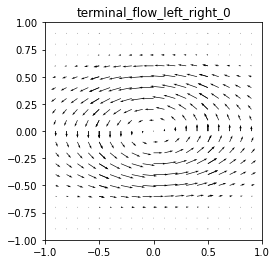

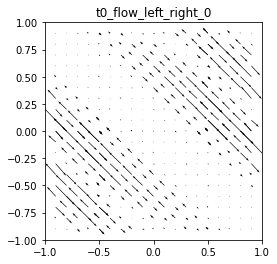

In [3]:
from mpi4py import MPI
from petsc4py import PETSc
import numpy as np
import pyvista

from dolfinx.fem import Constant,Function, FunctionSpace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
from dolfinx.io import XDMFFile
from dolfinx.mesh import create_unit_square, create_rectangle
from dolfinx.plot import create_vtk_mesh
from ufl import (FacetNormal, FiniteElement, Identity,TestFunction, TrialFunction, VectorElement,
                 div, dot, ds, dx, inner, lhs, nabla_grad, rhs, sym)

mesh = create_rectangle(
    MPI.COMM_WORLD,
    [np.array([-1, -1]), np.array([1, 1])],
    [10, 10]
)
t = 0
num_steps = 1000
T = 20
dt = T / num_steps
nu = .001

v_cg2 = VectorElement("CG", mesh.ufl_cell(), 2)
s_cg1 = FiniteElement("CG", mesh.ufl_cell(), 1)
V = FunctionSpace(mesh, v_cg2)
Q = FunctionSpace(mesh, s_cg1)

u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

def walls(x):
    return np.logical_or(np.isclose(x[1],-1), np.isclose(x[1],1))
wall_dofs = locate_dofs_geometrical(V, walls)
u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
bcu_noslip = dirichletbc(u_noslip, wall_dofs, V)
bcp_noslip = dirichletbc(PETSc.ScalarType(0), wall_dofs, Q)

def inflow_outflow(x):
    return np.logical_or(np.isclose(x[0],-1), np.isclose(x[0],1))
inflow_outflow_dofs = locate_dofs_geometrical(Q, inflow_outflow)
bc_inflow_outflow = dirichletbc(PETSc.ScalarType(0), inflow_outflow_dofs, Q)

bcu = [bcu_noslip]
bcp = [bc_inflow_outflow]
# bcp = [bcp_noslip]

alpha_for_f, beta_for_f = 2, 2
def f(x):
    return (1-x)**alpha_for_f * (1+x)**beta_for_f
def fprime(x):
    return (
        ((beta_for_f - alpha_for_f) - (beta_for_f + alpha_for_f) * x)
        * (1-x)**(alpha_for_f-1) 
        * (1+x)**(beta_for_f-1)
    )
def g(x):
    return 1 + x**2
def gprime(x):
    return 2 * x

def u_terminal(x):
    values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType)
    values[0] = fprime(x[1]) / f(x[1]) * np.exp(-g(x[0]) / f(x[1]))
    values[0] = np.where(
        np.logical_or(np.isclose(f(x[1]),0), np.isclose(g(x[0]),0)),
        np.zeros_like(values[0]),
        values[0]
    )
    values[1] = gprime(x[0]) / g(x[0]) * np.exp(-g(x[0]) / f(x[1]))
    values[1] = np.where(
        np.logical_or(np.isclose(f(x[1]),0), np.isclose(g(x[0]),0)),
        np.zeros_like(values[1]),
        values[1]
    )
    return values

u_n = Function(V)
u_n.name = "u_n"
u_n.interpolate(u_terminal)
U = 0.5 * (u_n + u)
n = FacetNormal(mesh)
f = Constant(mesh, PETSc.ScalarType((0,0)))
k = Constant(mesh, PETSc.ScalarType(dt))
mu = Constant(mesh, PETSc.ScalarType(1))
rho = Constant(mesh, PETSc.ScalarType(1))

# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(u.geometric_dimension())

# Define the variational problem for the first step
p_n = Function(Q)
p_n.name = "p_n"
F1 = rho*dot((u - u_n) / k, v)*dx
F1 += rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx
F1 += inner(sigma(U, p_n), epsilon(v))*dx
F1 += dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds
F1 -= dot(f, v)*dx
a1 = form(lhs(F1))
L1 = form(rhs(F1))

A1 = assemble_matrix(a1, bcs=bcu)
A1.assemble()
b1 = create_vector(L1)

# Define variational problem for step 2
u_ = Function(V)
a2 = form(dot(nabla_grad(p), nabla_grad(q))*dx)
L2 = form(dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx)
A2 = assemble_matrix(a2, bcs=bcp)
A2.assemble()
b2 = create_vector(L2)

# Define variational problem for step 3
p_ = Function(Q)
a3 = form(dot(u, v)*dx)
L3 = form(dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx)
A3 = assemble_matrix(a3)
A3.assemble()
b3 = create_vector(L3)

# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.HYPRE)
pc1.setHYPREType("boomeramg")

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm)
solver2.setOperators(A2)
solver2.setType(PETSc.KSP.Type.BCGS)
pc2 = solver2.getPC()
pc2.setType(PETSc.PC.Type.HYPRE)
pc2.setHYPREType("boomeramg")

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm)
solver3.setOperators(A3)
solver3.setType(PETSc.KSP.Type.CG)
pc3 = solver3.getPC()
pc3.setType(PETSc.PC.Type.SOR)

def u_exact(x):
    values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType)
    values[0] = 4*x[1]*(1.0 - x[1])
    return values
u_ex = Function(V)
u_ex.interpolate(u_exact)

plot_quiver(V, u_n, "terminal_flow_left_right_0")

for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    assemble_vector(b1, L1)
    apply_lifting(b1, [a1], [bcu])
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b1, bcu)
    solver1.solve(b1, u_.vector)
    u_.x.scatter_forward()
    
    # Step 2: Pressure corrrection step
    with b2.localForm() as loc_2:
        loc_2.set(0)
    assemble_vector(b2, L2)
    apply_lifting(b2, [a2], [bcp])
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b2, bcp)
    solver2.solve(b2, p_.vector)
    p_.x.scatter_forward()

    # Step 3: Velocity correction step
    with b3.localForm() as loc_3:
        loc_3.set(0)
    assemble_vector(b3, L3)
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    solver3.solve(b3, u_.vector)
    u_.x.scatter_forward()
    # Update variable with solution form this time step
    u_n.x.array[:] = u_.x.array[:]
    p_n.x.array[:] = p_.x.array[:]
plot_quiver(V, u_n, "t0_flow_left_right_0")

In [ ]:
from mpi4py import MPI
from petsc4py import PETSc
import numpy as np
import pyvista

from dolfinx.fem import Constant,Function, FunctionSpace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
from dolfinx.io import XDMFFile
from dolfinx.mesh import create_unit_square, create_rectangle
from dolfinx.plot import create_vtk_mesh
from ufl import (FacetNormal, FiniteElement, Identity,TestFunction, TrialFunction, VectorElement,
                 div, dot, ds, dx, inner, lhs, nabla_grad, rhs, sym)

mesh = create_rectangle(
    MPI.COMM_WORLD,
    [np.array([-1, -1]), np.array([1, 1])],
    [10, 10]
)
t = 0
num_steps = 1000
T = 20
dt = T / num_steps
nu = .001

v_cg2 = VectorElement("CG", mesh.ufl_cell(), 2)
s_cg1 = FiniteElement("CG", mesh.ufl_cell(), 1)
V = FunctionSpace(mesh, v_cg2)
Q = FunctionSpace(mesh, s_cg1)

u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

def walls(x):
    return np.logical_or(np.isclose(x[1],-1), np.isclose(x[1],1))
wall_dofs = locate_dofs_geometrical(V, walls)
u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
bcu_noslip = dirichletbc(u_noslip, wall_dofs, V)
bcp_noslip = dirichletbc(PETSc.ScalarType(0), wall_dofs, Q)

def inflow_outflow(x):
    return np.logical_or(np.isclose(x[0],-1), np.isclose(x[0],1))
inflow_outflow_dofs = locate_dofs_geometrical(Q, inflow_outflow)
bc_inflow_outflow = dirichletbc(PETSc.ScalarType(0), inflow_outflow_dofs, Q)

bcu = [bcu_noslip]
# bcp = [bc_inflow_outflow]
bcp = [bcp_noslip]

alpha_for_f, beta_for_f = 2, 2
def f(x):
    return (1-x)**alpha_for_f * (1+x)**beta_for_f
def fprime(x):
    return (
        ((beta_for_f - alpha_for_f) - (beta_for_f + alpha_for_f) * x)
        * (1-x)**(alpha_for_f-1) 
        * (1+x)**(beta_for_f-1)
    )
def g(x):
    return 1 + x**2
def gprime(x):
    return 2 * x

def u_terminal(x):
    values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType)
    values[0] = fprime(x[1]) / f(x[1]) * np.exp(-g(x[0]) / f(x[1]))
    values[0] = np.where(
        np.logical_or(np.isclose(f(x[1]),0), np.isclose(g(x[0]),0)),
        np.zeros_like(values[0]),
        values[0]
    )
    values[1] = gprime(x[0]) / g(x[0]) * np.exp(-g(x[0]) / f(x[1]))
    values[1] = np.where(
        np.logical_or(np.isclose(f(x[1]),0), np.isclose(g(x[0]),0)),
        np.zeros_like(values[1]),
        values[1]
    )
    return values

u_n = Function(V)
u_n.name = "u_n"
u_n.interpolate(u_terminal)
U = 0.5 * (u_n + u)
n = FacetNormal(mesh)
f = Constant(mesh, PETSc.ScalarType((0,0)))
k = Constant(mesh, PETSc.ScalarType(dt))
mu = Constant(mesh, PETSc.ScalarType(1))
rho = Constant(mesh, PETSc.ScalarType(1))

# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(u.geometric_dimension())

# Define the variational problem for the first step
p_n = Function(Q)
p_n.name = "p_n"
F1 = rho*dot((u - u_n) / k, v)*dx
F1 += rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx
F1 += inner(sigma(U, p_n), epsilon(v))*dx
F1 += dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds
F1 -= dot(f, v)*dx
a1 = form(lhs(F1))
L1 = form(rhs(F1))

A1 = assemble_matrix(a1, bcs=bcu)
A1.assemble()
b1 = create_vector(L1)

# Define variational problem for step 2
u_ = Function(V)
a2 = form(dot(nabla_grad(p), nabla_grad(q))*dx)
L2 = form(dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx)
A2 = assemble_matrix(a2, bcs=bcp)
A2.assemble()
b2 = create_vector(L2)

# Define variational problem for step 3
p_ = Function(Q)
a3 = form(dot(u, v)*dx)
L3 = form(dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx)
A3 = assemble_matrix(a3)
A3.assemble()
b3 = create_vector(L3)

# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.HYPRE)
pc1.setHYPREType("boomeramg")

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm)
solver2.setOperators(A2)
solver2.setType(PETSc.KSP.Type.BCGS)
pc2 = solver2.getPC()
pc2.setType(PETSc.PC.Type.HYPRE)
pc2.setHYPREType("boomeramg")

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm)
solver3.setOperators(A3)
solver3.setType(PETSc.KSP.Type.CG)
pc3 = solver3.getPC()
pc3.setType(PETSc.PC.Type.SOR)

def u_exact(x):
    values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType)
    values[0] = 4*x[1]*(1.0 - x[1])
    return values
u_ex = Function(V)
u_ex.interpolate(u_exact)

plot_quiver(V, u_n, "terminal_flow_top_btm_0")

for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    assemble_vector(b1, L1)
    apply_lifting(b1, [a1], [bcu])
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b1, bcu)
    solver1.solve(b1, u_.vector)
    u_.x.scatter_forward()
    
    # Step 2: Pressure corrrection step
    with b2.localForm() as loc_2:
        loc_2.set(0)
    assemble_vector(b2, L2)
    apply_lifting(b2, [a2], [bcp])
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b2, bcp)
    solver2.solve(b2, p_.vector)
    p_.x.scatter_forward()

    # Step 3: Velocity correction step
    with b3.localForm() as loc_3:
        loc_3.set(0)
    assemble_vector(b3, L3)
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    solver3.solve(b3, u_.vector)
    u_.x.scatter_forward()
    # Update variable with solution form this time step
    u_n.x.array[:] = u_.x.array[:]
    p_n.x.array[:] = p_.x.array[:]
plot_quiver(V, u_n, "t0_flow_top_btm_0")

  values[0] = fprime(x[1]) / f(x[1]) * np.exp(-g(x[0]) / f(x[1]))

  values[0] = fprime(x[1]) / f(x[1]) * np.exp(-g(x[0]) / f(x[1]))

  values[1] = gprime(x[0]) / g(x[0]) * np.exp(-g(x[0]) / f(x[1]))

